# Inflation of a simplified left ventricle

**Notebook prepared by 

Joakim Sundnes**

Date: **July 1, 2021**


## Model outline
We will now increase the realism *slightly*, and consider the classic ellipsoid approximation of the left ventricle (LV). We will use the Guccione material model introduced previously, and the additional complexity is mainly in the geometry and that fiber orientation is not constant.

We will look at two simple cases:
* Passive inflation: the ellipsoidal LV is simply inflated, by ramping up the endocardial pressure.
* Active contraction: the LV contracts against a constant endocardial pressure.

The two cases are very similar to benchmark problems 2 and 3 in this paper:
* [Mechanics benchmark Land et al 2015](./mech_benchmark.pdf)

The geometry is identical (except that we will here use a very coarse grid), while there are small differences in boundary conditions and fiber orientation.

As above, the mathematic problem to be solved is a quasi-static hyper-elasticity problem, with a combination of Dirichlet and Neumann boundary conditions:
$$
 \begin{alignat*}{2}
    - \nabla\cdot P &= 0 && \quad \text{ in } \Omega \\
    u &= 0 && \quad \text{ on } \Gamma_{\mathrm{D}} \\
    P \cdot n &= T && \quad \text{ on } \Gamma_{\mathrm{N}} \\
    P \cdot n &= 0 && \quad \text{ on } \Gamma_{\mathrm{0}}
  \end{alignat*}
$$
As above, $P$ is the first Piola-Kirchhoff stress tensor, $u$ is the displacement, $T$ is a load applied to parts of the boundary, and $\Omega, \Gamma_{\mathrm{D}}, \Gamma_{\mathrm{N}},\Gamma_{\mathrm{0}}$ are the domain and the boundaries for Dirichlet- and Neumann boundary conditions, respectively. The domain is a truncated ellipsoid as shown here:

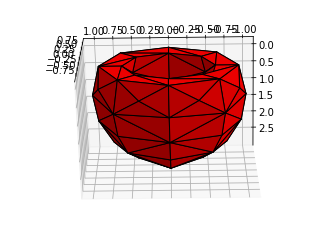

In [3]:
from fenics import *
import matplotlib.pyplot as plt

mesh = Mesh(MPI.comm_world, "data/mesh.xml")

plot(mesh, edgecolor='k', color="r")

ax = plt.gca()
ax.view_init(elev=-67, azim=-179)
plt.show()

The mesh is very coarse, to minimize the compute time, and therefore looks edgy and non-smooth. For simplicity, we will hold the base of the LV fixed in all directions, the epicardial surface is unloaded, while a time-varying pressure is applied to the endocardial surface.

As above, we derive the weak form to apply the finite element method. Multipling with a test function   $v \in \hat{V}$, integrating by parts and applying the boundary conditions leads to the problem:

Find $u \in V$ such that
$$
\begin{equation*}
    \int_{\Omega} P : \nabla v dx
    = -\int_{\Gamma_{\mathrm{N}}} pJF^{-T}N \cdot v ds
  \end{equation*}
$$

We are now ready to set up our Fenics solver. In addition to the standard imports and settings, it will be useful to define a couple of helper function to handle the pre- and post-processing. The function 'load_ellipsoid_data' reads the goemetry and fiber information from a set of files, and returns a dolfin mesh and a list of functions defining the boundary markers and fiber orientation:

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from dolfin import *
from guccionematerial import *

parameters["form_compiler"]["quadrature_degree"] = 4
parameters["form_compiler"]["cpp_optimize"] = True


def load_ellipsoid_data():
    """Returns 4-tuple:
    mesh - the mesh, 
    mf - MeshFunction defining boundary markers, 
    numbering - dict of marking numbers,
    fibers - list of functions defining microstructure"""
  
    mesh = Mesh(MPI.comm_world, "data/mesh.xml")
    mf = MeshFunction("size_t", mesh, "data/facet_function.xml")

    numbering = {
        "BASE": 10,
        "ENDO": 30,
        "EPI": 40
    }

    # load fibers, sheet, cross_sheet data 
    fiber_element = VectorElement(family="Quadrature",
                                     cell=mesh.ufl_cell(),
                                     degree=4,
                                     quad_scheme="default")
    fiber_space = FunctionSpace(mesh, fiber_element)
    fiber = Function(fiber_space, "data/fiber.xml")
    sheet = Function(fiber_space, "data/sheet.xml")
    cross_sheet = Function(fiber_space, "data/cross_sheet.xml")

    fibers = [fiber,sheet, cross_sheet]
    
    return mesh, mf, numbering, fibers



We will use a transversely isotropic material model, so the only direction that really matters is the fiber orientation, but the solver requires teh sheet and sheet normal directions to be defined. The fiber field stored in the file 'data/fiber.xml' is a standard approximation where the fiber angle varies linearly from -60 to +60 degrees going from the endo- to epicardium, as illustrated in the figure below.

<img src="figs/fibers.png" width=400>

When doing mechanics simulations of the entire LV, it is interesting to look at the variations in cavity volume, to plot PV loops etc. For computing the cavity volume, we apply a small mathematical trick to turn a volume integral into a surface integral:
$$
V = \int_{cavity} 1 dx = -1/3\int_{\Gamma_N} x\cdot n ds ,
$$
where $x$ is the coordinate of the *deformed* surface, and $n$ is the deformed surface normal. With a Lagrangian approach we map everything to the reference configuration, and define the problem in terms of the displacement $u$, to get the following Fenics code:

In [11]:
def compute_cavity_volume(mesh,mf, numbering,u=None):
    X = SpatialCoordinate(mesh) 
    N = FacetNormal(mesh)

    if u is not None:
        I = Identity(3) # the identity matrix
        F = I + grad(u) # the deformation gradient
        J = det(F)
        vol_form = (-1.0/3.0) * dot(X + u,
                                           J * dolfin.inv(F).T * N)
    else:
        vol_form = (-1.0/3.0) * dot(X, N)


    ds = Measure('ds',domain=mesh,subdomain_data=mf)

    return assemble(vol_form*ds(numbering["ENDO"]))

The input to the function is a dolfin mesh, a MeshFunction defining the boundary markers, a dictionary containing the names of the boundary markers, and an optional displacement $u$. The function assumes that the endocardial surface is marked with boundary marker "ENDO". 

Having these two functions in place, the rest of the code is very similar to the unit cube problems considered previously. In fact, most of the additional complexity of working with an ellipsoid and non-constant fiber fields is handled in the 'load_ellipsoid_geometry' function. Once this function has been called to set up the boundary markers and fiber fields, the rest of the problem definition is quite similar to the unit cube problem considered previously. The following code is an incomplete solver code, where the definition of the material and the weak form is missing. Complete the code to finalize and run the LV solver. 

In [12]:
mesh, boundary_markers, numbering, fibers = load_ellipsoid_data()

V = VectorFunctionSpace(mesh,'P',1)

# Redefine boundary measure, to allow integration over parts of boundary
ds = Measure('ds',domain=mesh,subdomain_data=boundary_markers)

clamp = Constant((0.0, 0.0, 0.0))
bc = DirichletBC(V, clamp, boundary_markers, numbering["BASE"])
bcs = [bc]

# Define solution u and test function v
u = Function(V)
v = TestFunction(V)

"""
Now we have defined the geometry, Dirichlet boundary conditions and the function spaces. 
Specify the weak form to be solved, using the material model defined in the GuccioneMaterial
class. 
"""

'\nNow we have defined the geometry, Dirichlet boundary conditions and the function spaces. \nSpecify the weak form to be solved, using the material model defined in the GuccioneMaterial\nclass. \n'

In [13]:
# Step-wise loading 
pressure_steps = 20
target_pressure = 10.0

# Loop over load steps:
pressures = np.linspace(0,target_pressure,pressure_steps)
volumes = np.zeros_like(pressures)
for step in range(pressure_steps):
    p_endo.assign(pressures[step])
    solve(R == 0, u, bcs)
    # Compute and store volume for each step:
    volumes[step] = compute_cavity_volume(mesh,boundary_markers,numbering,u)

plt.figure(1)
plt.plot(volumes,pressures)
plt.xlabel('Volume')
plt.ylabel('Pressure')
plt.figure(2)

# Move mesh according to displacement
u_int = dolfin.interpolate(u, VectorFunctionSpace(mesh, "CG", 1))
moved_mesh = Mesh(mesh)
ALE.move(moved_mesh, u_int)

# Plot the result on to of the original
plot(moved_mesh, alpha=0.1, edgecolor='k', color='w')
plot(mesh, color="r")

ax = plt.gca()
ax.view_init(elev=-67, azim=-179)
ax.set_axis_off()
plt.show()

NameError: name 'p_endo' is not defined

The top figure shows the pressure-volume relation, with volume on the horizontal and pressure on the vertical axis. This order of plotting may seem a bit unusual since pressure is the input to our problem and volume the output, but it is the most common way to visualize pressure-volume data for the heart. The lower figure shows the inflated LV geometry compared with the original geometry. 

### Adding active contraction
The final step is to add active contraction in our ellipsoid problem. As we saw in the unit cube examples, the GuccioneMaterial class includes functionality for active stress. While simply ramping up the pressure worked is a reasonably realistic approximation of the filling phase of the cardiac cycle, proper simulation of the complete cardiac cycle requires far more complex boundary conditions. For a full cardiac cycle, the pressure volume relation (PV loop) looks as follows:
<img src="figs/pv_loop.png" width=400>

This loop has four characteristic phases, with different hemodynamic boundary conditions:
* The filling phase, where pressure and volume both increase. This is the phase we modeled above, by simply ramping up the endocardial pressure. In a real LV, the mitral valve is open during this phase, while the aortic valve is closed. 
* As the ventricle starts contracting, the LV pressure becomes higher than the pressure in the pulmonary veins, which causes the mitral valve to close. This marks the end of diastole (ED). The heart enters the *isovolumic contraction* phase, where the pressure increases while the volume stays constant since both valves are closed. In a heart mechanics model, realistic boundary conditions would require solving a non-linear equation to find the cavity pressure that keeps the volume constant as active stress increases.
* At some point the LV pressure will exceed the aortic pressure, and the aortic valve opens and allows blood to be ejected into the systemc circulation. This is the *ejection phase*, and the endocardial pressure will be determined by the contractile force and the compliance and resistance of the systemic circulation. The typical boundary condition to use for this phase is a so-called Windkessel model.
* Finally, as the pressure in the LV starts to drop, the aortic valve closes and the heart enters the *isovolumic relaxation* phase. This is the end-systolic (ES) point. In terms of boundary conditions this phase is identicl to isovolumic contraction.

One can define relatively simple models that give a reasonably realistic representation of the four phases above. However, in this course we will keep things even simpler, and simply let our LV contract against a constant endocardial pressure. The resulting simulation will be a reasonably realistic filling phase, followed by a less realistic ejection phase (and no isovolumic phase in between). The simulation protocol should look something like this:
* First keep the tissue passive, and inflate the LV to a given pressure (filling phase)
* Then, hold the pressure constant while ramping up the active stress

In code, the time course of endocardial pressure and active stress will look something like:

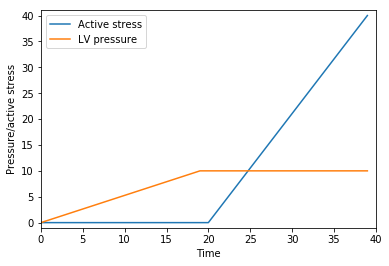

In [14]:
# Step-wise loading 
pressure_steps = 20
active_steps = 20
target_pressure = 10.0
target_active = 40.0

#first ramp up pressure, then keep constant
filling_pressure = np.linspace(0,target_pressure,pressure_steps)
const_pressure = np.ones(active_steps)*target_pressure
pressures = np.concatenate((filling_pressure,const_pressure))

#zero active tension during filling, then increase linearly
active1 = np.zeros_like(filling_pressure)
active2 = np.linspace(0,target_active, active_steps)
active =  np.concatenate((active1, active2))

plt.plot(active)
plt.plot(pressures)
plt.legend(['Active stress','LV pressure'])
plt.xlabel('Time')
plt.ylabel('Pressure/active stress')
plt.axis([0, 40, -1, 41])

plt.show()


## Final assignment
* Add the varying pressure- and active stress defined above to the LV solver defined above. 
* What does the resulting PV loop look like? Is this what you expected?
* Optional: How can you change the solver to simulate the isovolumic contraction phase?